In [1]:
import altair as alt
import cnvutils
import cptac
import IPython.display
import numpy as np
import os
import pandas as pd
import statsmodels

from cnvutils.filenames import (
    get_has_event_path,
    get_ttest_results_path,
    get_protein_ttest_boxplot_path,
    get_all_props_path,
    get_proportions_perm_p_values_path,
)

from cnvutils.constants import (
    CHART_FORMAT,
    CHART_RENDER_METHOD,
    CHART_SCALE,
    SIG_CUTOFF,
)

from cnvutils.load_data import (
    get_cnv_counts,
    get_tables,
    get_ensembl_gene_locations,
    get_ncbi_gene_locations,
)

from cnvutils.chromosome_funcs import (
    select_genes_for_event,
)

In [2]:
all_props = pd.read_csv(get_all_props_path(
    data_dir=os.path.join(os.getcwd(), "..", "data"),
    chromosome=8,
), sep="\t")

sig = all_props[
    (all_props["prop_name"] == "sig_prop") &
    (all_props["proteomics_or_transcriptomics"] == "proteomics") &
    (all_props["source"] == "gistic")
].\
dropna(how="any", axis=0).\
reset_index(drop=True)

sig = sig.\
assign(diff=sig["not_has_prop"] - sig["has_prop"]).\
drop(columns=[
    "not_has_prop",
    "has_prop",
    "proteomics_or_transcriptomics",
    "source",
    "level",
    "prop_name",
])

sig

,chromosome,arm,gain_or_loss,cis_or_trans,cancer_types,diff
0,8,p,loss,cis,coad,0.073684
1,8,p,loss,cis,hnscc,0.117188
2,8,p,loss,cis,lscc,0.013986
3,8,p,loss,cis,luad,0.161972
4,8,p,loss,cis,ov,-0.122951
5,8,p,loss,cis,pdac,0.472441
6,8,p,loss,trans,coad,0.117099
7,8,p,loss,trans,hnscc,0.095388
8,8,p,loss,trans,lscc,0.063028
9,8,p,loss,trans,luad,0.097555


In [3]:
def split_groups(df, split_cols, results, prefix):
    """Recursively split proportions into subgroups and run t-tests on subgroups."""
    
    if len(split_cols) == 0:
        return
    
    col = split_cols[0]
    for val in df[col].unique():
        
        group = df[df[col] == val]
        new_prefix = "_".join([prefix, val])
        group = group.assign(
            group=new_prefix
        )
        
        results.append(group)
        
        split_groups(
            df=group,
            split_cols=split_cols[1:],
            results=results,
            prefix=new_prefix,
        )

In [4]:
res = [sig.assign(group="p_all")]
split_groups(
    df=sig,
    split_cols=[
        "cis_or_trans",
        "gain_or_loss",
    ],
    results=res,
    prefix="p",
)

plt = pd.concat(res)

In [5]:
plt

,chromosome,arm,gain_or_loss,cis_or_trans,cancer_types,diff,group
0,8,p,loss,cis,coad,0.073684,p_all
1,8,p,loss,cis,hnscc,0.117188,p_all
2,8,p,loss,cis,lscc,0.013986,p_all
3,8,p,loss,cis,luad,0.161972,p_all
4,8,p,loss,cis,ov,-0.122951,p_all
5,8,p,loss,cis,pdac,0.472441,p_all
6,8,p,loss,trans,coad,0.117099,p_all
7,8,p,loss,trans,hnscc,0.095388,p_all
8,8,p,loss,trans,lscc,0.063028,p_all
9,8,p,loss,trans,luad,0.097555,p_all


In [6]:
p_path = get_proportions_perm_p_values_path(
    data_dir=os.path.join(os.getcwd(), "..", "data"),
    chromosome=8,
)

p_vals = pd.read_csv(p_path, sep="\t")

# Filter out just the p values we want
p_vals = p_vals[p_vals["group"] == "sig_props"][["name", "p"]]
p_vals = p_vals[p_vals["name"].str.contains("gistic")]

# Benjamini-Hochberg FDR correction
reject, adj_p, alphac_sidak, alphac_bonf = statsmodels.stats.multitest.multipletests(
    pvals=p_vals["p"],
    alpha=SIG_CUTOFF,
    method="fdr_bh",
)

p_vals = p_vals.assign(adj_p=adj_p)

p_vals = p_vals[p_vals["name"].str.contains("proteomics")]

p_vals = p_vals.assign(
    name=p_vals["name"].str.replace("_gistic_proteomics", "").replace({"p": "p_all"})
).drop(columns="p")

In [7]:
p_vals

,name,adj_p
79,p_all,0.064125
80,p_cis,0.036857
81,p_cis_gain,0.197250
82,p_cis_loss,0.027000
83,p_trans,0.112200
84,p_trans_gain,0.412929
85,p_trans_loss,0.025000


In [8]:
plt = plt.merge(
    p_vals,
    how="inner",
    left_on="group",
    right_on="name",
)

In [9]:
plt

,chromosome,arm,gain_or_loss,cis_or_trans,cancer_types,diff,group,name,adj_p
0,8,p,loss,cis,coad,0.073684,p_all,p_all,0.064125
1,8,p,loss,cis,hnscc,0.117188,p_all,p_all,0.064125
2,8,p,loss,cis,lscc,0.013986,p_all,p_all,0.064125
3,8,p,loss,cis,luad,0.161972,p_all,p_all,0.064125
4,8,p,loss,cis,ov,-0.122951,p_all,p_all,0.064125
5,8,p,loss,cis,pdac,0.472441,p_all,p_all,0.064125
6,8,p,loss,trans,coad,0.117099,p_all,p_all,0.064125
7,8,p,loss,trans,hnscc,0.095388,p_all,p_all,0.064125
8,8,p,loss,trans,lscc,0.063028,p_all,p_all,0.064125
9,8,p,loss,trans,luad,0.097555,p_all,p_all,0.064125


In [10]:
plt = plt.assign(sig=(plt["adj_p"] <= SIG_CUTOFF).replace({True: "p <= 0.05", False: "p > 0.05"}))
p_vals = p_vals.assign(sig=(p_vals["adj_p"] <= SIG_CUTOFF).replace({True: "p <= 0.05", False: "p > 0.05"}))

bp = alt.Chart(plt).mark_boxplot(
    size=50,
    extent='min-max',
).encode(
    x=alt.X(
        "group",
        axis=alt.Axis(
            title=None,
            labelAngle=-30,
        )
    ),
    y=alt.Y(
        "diff",
        title="(No event prop affected) - (Has event prop affected)",
    ),
    color=alt.Color(
        "sig",
        title=None,
        scale=alt.Scale(
            domain=["p <= 0.05", "p > 0.05"],
            range=["#54a24b", "#4c78a8"]
        ),
    ),
).properties(
    width=500,
)

p_vals = p_vals.\
assign(
    line=-np.log10(SIG_CUTOFF),
    neg_log_adj_p=-np.log10(p_vals["adj_p"]),
)

base = alt.Chart(p_vals)

dots = base.mark_point(
    filled=True,
    opacity=1,
).encode(
    x=alt.X(
        "name",
        axis=alt.Axis(
            title=None,
            labels=False,
            ticks=False,
        ),
    ),
    y=alt.Y(
        "neg_log_adj_p",
        axis=alt.Axis(
            title="-log(p)",
            titlePadding=15,
        ),
    ),
    color=alt.Color(
        "sig",
    )
)

line = base.mark_rule(color="crimson").encode(
    y="line"
)

mhp = (dots + line).properties(
    width=500,
    height=100
)

xax = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(
    opacity=0.2,
).encode(y='y')

final = alt.vconcat(
    mhp,
    bp + xax,
    spacing=15,
).properties(
    title="",
).configure_axis(
    grid=False,
    domainWidth=1,
    domainColor="black",
).configure_title(
    fontSize=15,
    anchor="middle",
    orient="top",
    dy=20,
).configure_view(
    strokeOpacity=0,
)

In [11]:
final.save("final.png", method=CHART_RENDER_METHOD, scale_factor=CHART_SCALE)

INFO:tornado.access:200 GET / (::1) 4.64ms
INFO:tornado.access:200 GET / (::1) 4.64ms
INFO:tornado.access:200 GET /vega.js (::1) 3.94ms
INFO:tornado.access:200 GET /vega.js (::1) 3.94ms
INFO:tornado.access:200 GET /vega-lite.js (::1) 6.06ms
INFO:tornado.access:200 GET /vega-lite.js (::1) 6.06ms
INFO:tornado.access:200 GET /vega-embed.js (::1) 7.85ms
INFO:tornado.access:200 GET /vega-embed.js (::1) 7.85ms


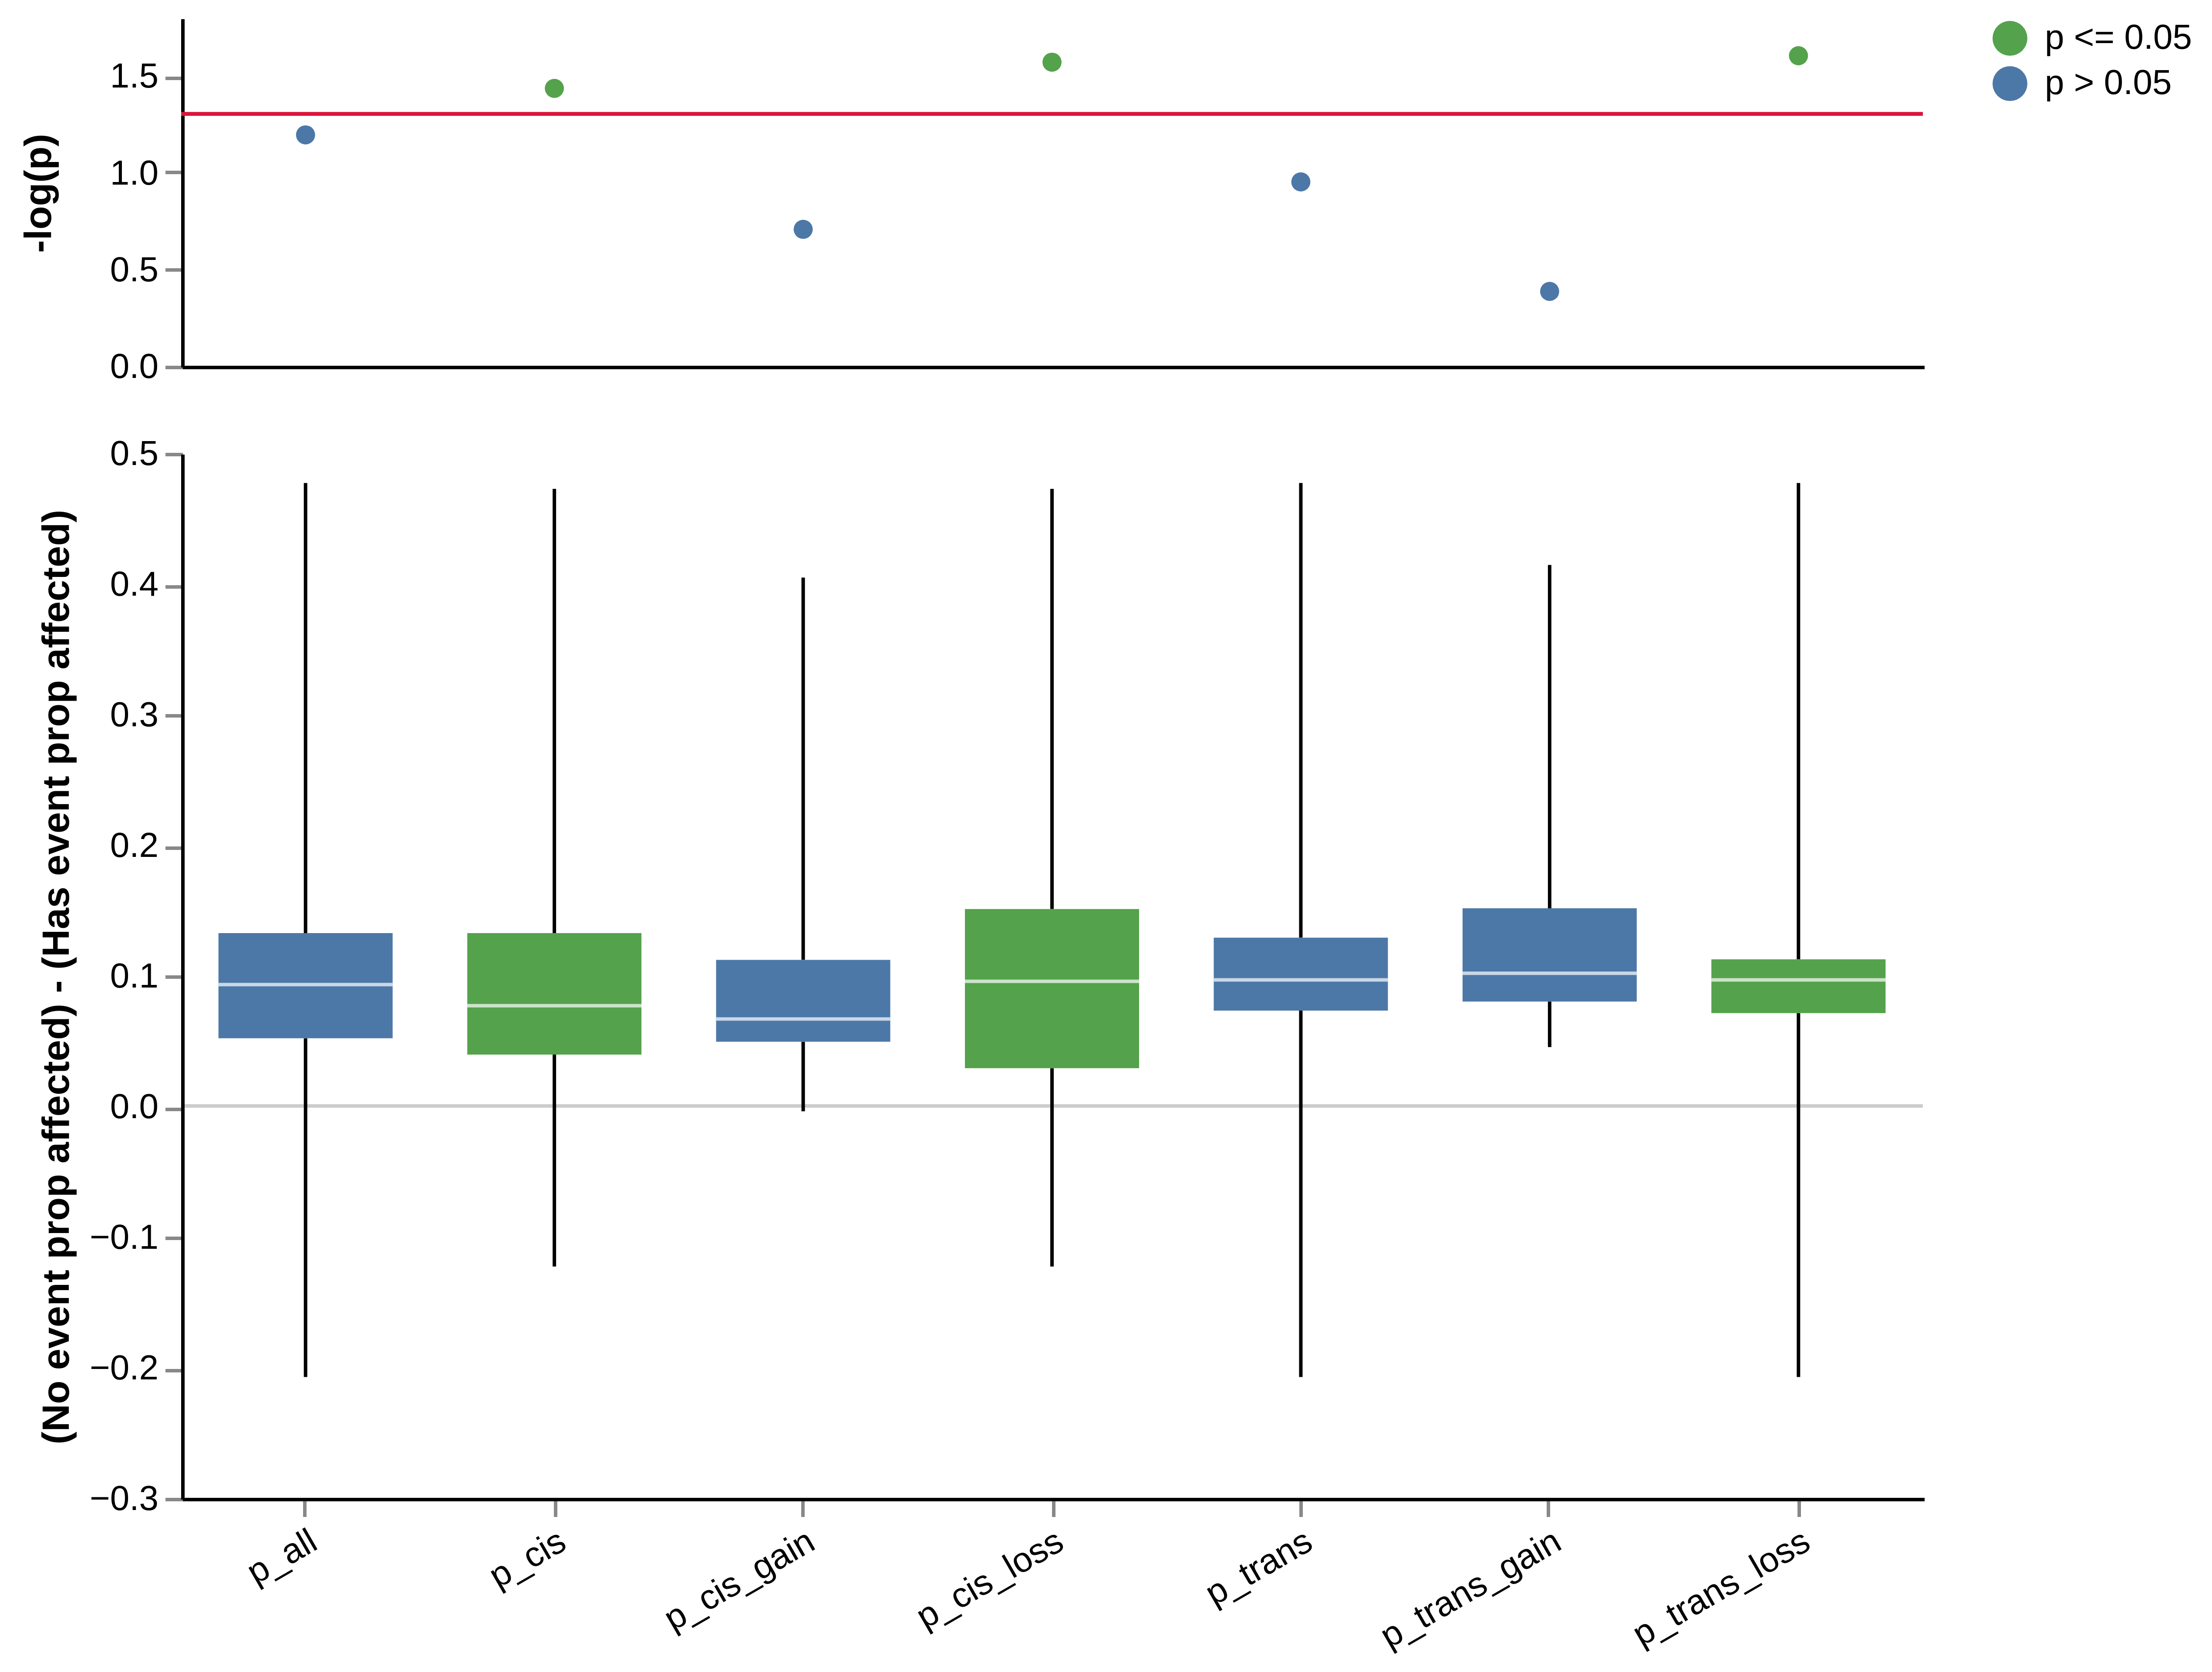

In [12]:
IPython.display.Image("final.png")